In [1]:
# Import packages and set seed for reproducibility
import sys
import torch
import os
import json
import time
import random

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sn

from tqdm import tqdm

import cv2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as album
import gc
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
gc.collect()
torch.cuda.empty_cache()


In [2]:
def set_seed(seed, use_gpu=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        print("CUDA is available")
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 12345
USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())
# Use metadata to get image and mask paths


CUDA is available


In [3]:
DATA_PATH = "./data"
## Read files
train_metadata_df = pd.read_csv(os.path.join(DATA_PATH, "train_metadata_patches256.csv"))
print(train_metadata_df.shape)

train_metadata_df.head()
valid_metadata_df = pd.read_csv(os.path.join(DATA_PATH, "valid_metadata_patches256.csv"))
print(valid_metadata_df.shape)

valid_metadata_df.head()
test_metadata_df = pd.read_csv(os.path.join(DATA_PATH, "test_metadata_patches256.csv"))
print(test_metadata_df.shape)

test_metadata_df.head()
## Change paths
train_metadata_df["sat_image_path"] = train_metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_PATH, img_pth))
train_metadata_df["mask_path"] = train_metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_PATH, mask_pth))

train_metadata_df.head()
valid_metadata_df["sat_image_path"] = valid_metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_PATH, img_pth))
valid_metadata_df["mask_path"] = valid_metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_PATH, mask_pth))

valid_metadata_df.head()
test_metadata_df["sat_image_path"] = test_metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_PATH, img_pth))
test_metadata_df["mask_path"] = test_metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_PATH, mask_pth))

test_metadata_df.head()



(55566, 3)
(4704, 3)
(5488, 3)


,image_id,sat_image_path,mask_path
0,GF2_PMS1__L1A0001680851-MSS1,./data\test_patches256/GF2_PMS1__L1A0001680851...,./data\test_patches256/GF2_PMS1__L1A0001680851...
1,GF2_PMS1__L1A0001680851-MSS1,./data\test_patches256/GF2_PMS1__L1A0001680851...,./data\test_patches256/GF2_PMS1__L1A0001680851...
2,GF2_PMS1__L1A0001680851-MSS1,./data\test_patches256/GF2_PMS1__L1A0001680851...,./data\test_patches256/GF2_PMS1__L1A0001680851...
3,GF2_PMS1__L1A0001680851-MSS1,./data\test_patches256/GF2_PMS1__L1A0001680851...,./data\test_patches256/GF2_PMS1__L1A0001680851...
4,GF2_PMS1__L1A0001680851-MSS1,./data\test_patches256/GF2_PMS1__L1A0001680851...,./data\test_patches256/GF2_PMS1__L1A0001680851...


In [4]:
# Get class names and RGB values
class_dict = pd.read_csv(os.path.join(DATA_PATH, "class_dict.csv"))
class_dict
# list of class names
class_names = class_dict["name"].tolist()
# list of RGB values for each class
class_rgb_values = class_dict[["r", "g", "b"]].values.tolist()
format_spec = "{:<20} {:<20}"

print(format_spec.format("class name:", "class RGB values:"), "\n")

for i in range(len(class_names)):
    print(format_spec.format(str(class_names[i]), str(class_rgb_values[i])))

class name:          class RGB values:    

built-up             [255, 0, 0]         
farmland             [0, 255, 0]         
forest               [0, 255, 255]       
meadow               [255, 255, 0]       
water                [0, 0, 255]         
unknown              [0, 0, 0]           


In [5]:
# # Create a custom dataset class
# class DeepGlobeLandCover(Dataset):

#     def __init__(self, df, class_rgb_values=None, transform=None):

#         self.image_paths = df["sat_image_path"].tolist()
#         self.mask_paths = df["mask_path"].tolist()

#         self.class_rgb_values = class_rgb_values
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_paths)
    
#     def __getitem__(self, i):
        
#         image = cv2.imread(self.image_paths[i])
#         mask = cv2.imread(self.mask_paths[i])

#         if self.transform:
#             sample = self.transform(image=image, mask=mask)
#             image, mask = sample["image"], sample["mask"]

#         mask = rgb_to_dense_encoding(mask, self.class_rgb_values)

#         image = torch.from_numpy(image).permute(2, 0, 1)
#         mask = torch.from_numpy(mask)

#         return image, mask
class DeepGlobeLandCover(Dataset):
    def __init__(self, df, class_rgb_values=None, transform=None):
        self.image_paths = df["sat_image_path"].tolist()
        self.mask_paths = df["mask_path"].tolist()
        self.class_rgb_values = class_rgb_values
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        image = cv2.imread(self.image_paths[i])
        mask = cv2.imread(self.mask_paths[i])

        # Ensure mask has 3 channels
        if mask is None or len(mask.shape) != 3 or mask.shape[2] != 3:
            raise ValueError(f"Invalid mask at index {i}, shape: {mask.shape if mask is not None else None}")

        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        
        # Convert mask from RGB to dense encoding
        mask = rgb_to_dense_encoding(mask, self.class_rgb_values)

        # Convert image to tensor
        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask)

        return image, mask


In [6]:
# Shuffle data and select train, valid, and test set sizes
train_metadata_df_shuffled = train_metadata_df.sample(frac=1, random_state=0).reset_index(drop=True)
train_df = train_metadata_df_shuffled.iloc[:60000]
print("train:", len(train_df))
valid_metadata_df_shuffled = valid_metadata_df.sample(frac=1, random_state=0).reset_index(drop=True)
valid_df = valid_metadata_df_shuffled.iloc[:8000]
print("valid:", len(valid_df))
test_metadata_df_shuffled = test_metadata_df.sample(frac=1, random_state=0).reset_index(drop=True)
test_df = test_metadata_df_shuffled.iloc[:8000]
print("test:", len(test_df))

train: 55566
valid: 4704
test: 5488


In [7]:
# Define functions for different encodings (one-hot <> rgb <> dense)
def rgb_to_one_hot_encoding(mask_rgb, class_rgb_values):

    if mask_rgb.shape[2] != 3:
        raise ValueError("The number of channels must be 3")

    mask_one_hot = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1], len(class_rgb_values)), dtype="uint8")
    for i, rgb in enumerate(class_rgb_values):
        mask_one_hot[:, :, i] = np.all(np.equal(mask_rgb, rgb), axis=-1)

    return mask_one_hot
def rgb_to_dense_encoding(mask_rgb, class_rgb_values):

    if mask_rgb.shape[2] != 3:
        raise ValueError("The number of channels must be 3")

    mask_dense = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype="uint8")
    for i, rgb in enumerate(class_rgb_values):
        mask_dense[np.all(np.equal(mask_rgb, rgb), axis=-1)] = i

    return mask_dense
def dense_to_rgb_encoding(mask_dense, class_rgb_values):

    if len(mask_dense.shape) != 2:
        raise ValueError("The number of channels must be 1")

    mask_rgb = np.zeros((mask_dense.shape[0], mask_dense.shape[1], 3), dtype="uint8")
    for i, rgb in enumerate(class_rgb_values):
        mask_rgb[mask_dense == i, :] = rgb

    return mask_rgb
def one_hot_to_rgb_encoding(mask_one_hot, class_rgb_values):

    if mask_one_hot.shape[2] != len(class_rgb_values):
        raise ValueError("The number of channels must be " + str(len(class_rgb_values)))

    mask_dense = np.argmax(mask_one_hot, axis=-1)
    mask_rgb = dense_to_rgb_encoding(mask_dense, class_rgb_values)

    return mask_rgb

In [8]:
# Class distributions and weights (median frequency balancing)
FREQ = True
def task_pixels(mask_path):

    mask = cv2.imread(mask_path)
    mask = rgb_to_dense_encoding(mask, class_rgb_values)

    unique, counts = np.unique(mask, return_counts=True)
    return (unique, counts)

if FREQ:
    sparse_pixels = [task_pixels(path) for path in tqdm(train_df["mask_path"].tolist())]

    pixels = np.zeros((len(sparse_pixels), 7))

    for i in range(len(sparse_pixels)):
        pixels[i, sparse_pixels[i][0]] = sparse_pixels[i][1]
total_pixels_per_class = pixels.sum(axis=0)

total_pixels = total_pixels_per_class.sum()

distr = total_pixels_per_class / total_pixels

assert np.isclose(distr.sum(), 1), "Sum of distribution is not equal to 1"

print(distr)

100%|██████████| 55566/55566 [10:20<00:00, 89.50it/s]


[0.15084652 0.34913148 0.06891692 0.00762519 0.08419963 0.33928026
 0.        ]


In [9]:
# Get size of an image and a mask
# get image and mask paths of an image
idx = 1
image_path = train_df["sat_image_path"][idx]
mask_path = train_df["mask_path"][idx]

# read image and mask into a numpy array and convert from BGR to RGB
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)


def get_size(image, mask):

    format_spec = "{:<10} {:<26} {:<18} {:<16} {:<14}"

    image_size = sys.getsizeof(image)/10**6
    mask_size = sys.getsizeof(mask)/10**6

    if torch.is_tensor(image) and torch.is_tensor(mask):
        image_size = sys.getsizeof(image.storage())/10**6
        mask_size = sys.getsizeof(mask.storage())/10**6

    print(format_spec.format("name:", "object type:", "shape:", "data type:", "size [Mb]:"), "\n")
    print(format_spec.format("image", str(type(image)), str(list(image.shape)), str(image.dtype), str(round(image_size, 2))))
    print(format_spec.format("mask", str(type(mask)), str(list(mask.shape)), str(mask.dtype), str(round(mask_size, 2))))

get_size(image, mask)

name:      object type:               shape:             data type:       size [Mb]:     

image      <class 'numpy.ndarray'>    [256, 256, 3]      uint8            0.2           
mask       <class 'numpy.ndarray'>    [256, 256, 3]      uint8            0.2           


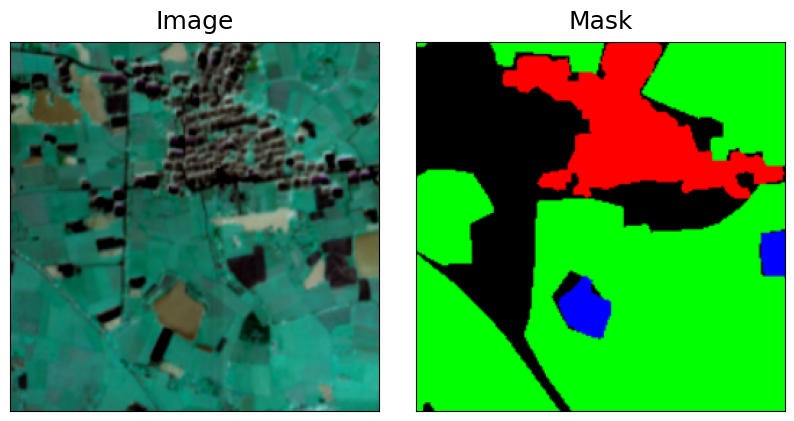

In [10]:
# Visualize images and masks
# get image and mask paths of an image
idx = 1
image_path = train_df["sat_image_path"][idx]
mask_path = train_df["mask_path"][idx]

# read image and mask into a numpy array
image = cv2.imread(image_path)
mask = cv2.imread(mask_path)

# plot image
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

plt.subplot(1,2,1)
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.title("Image", fontsize=18, pad=10)

plt.subplot(1,2,2)
plt.imshow(mask)
plt.xticks([])
plt.yticks([])
plt.title("Mask", fontsize=18, pad=10)

plt.show()

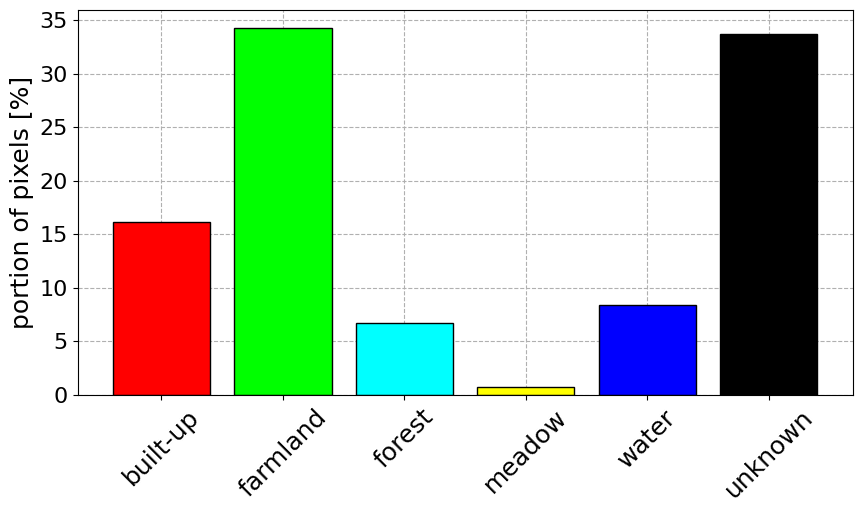

In [11]:
distr = np.array([0.16138614, 0.34260766, 0.06750223, 0.00764113, 0.08391151, 0.33695133])
assert (abs(distr.sum() - 1) < 0.001)
fig = plt.subplots(figsize=(10,5))

plt.bar([s.split("_")[0] for s in class_names], distr*100,
        color=np.array(class_rgb_values)/255,
        path_effects=([pe.Stroke(linewidth=1, foreground="black")]),
        zorder=2)

plt.grid(ls="--", zorder=1)

plt.ylabel("portion of pixels [%]", fontsize=18)
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=16)

plt.savefig("./images/portion_of_pixels_dl.png", dpi=300, bbox_inches="tight")

plt.show()

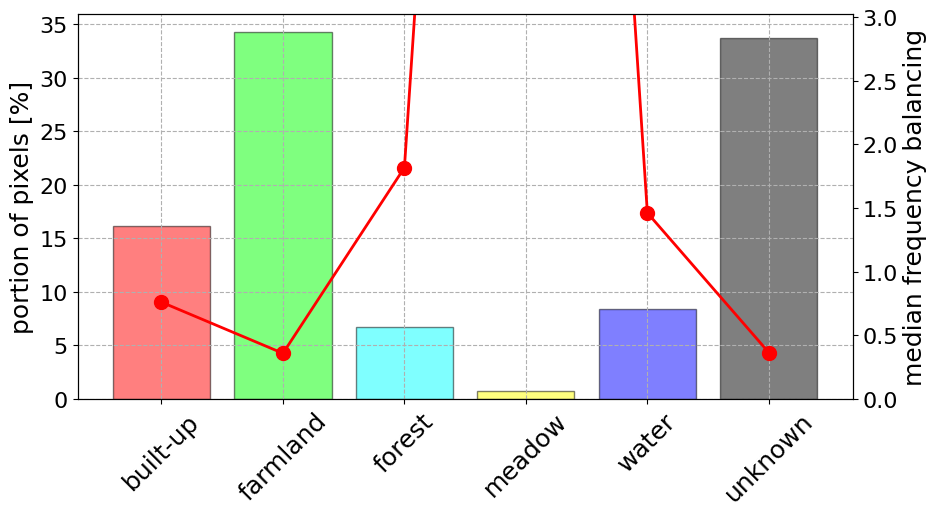

In [12]:
freq = np.array([0.16138614, 0.34260766, 0.06750223, 0.00764113, 0.08391151, 0.33695133])

class_weight = np.median(freq)/freq
fig, axes1 = plt.subplots(figsize=(10,5))

axes1.grid(ls="--")

axes1.bar([s.split("_")[0] for s in class_names], distr*100,
          color=np.array(class_rgb_values)/255, alpha=0.5,
          path_effects=([pe.Stroke(linewidth=1, foreground="black")]))

axes1.xaxis.set_tick_params(labelsize=18, rotation=45)
axes1.yaxis.set_tick_params(labelsize=16)
axes1.set_ylabel("portion of pixels [%]", fontsize=18)

axes2 = axes1.twinx()
axes2.plot([s.split("_")[0] for s in class_names], class_weight,
           linestyle="-", linewidth=2, marker="o", markersize=10, color="red")
axes2.set_ylim(bottom=0, top=3.025)
axes2.xaxis.set_tick_params(labelsize=18, rotation=45)
axes2.yaxis.set_tick_params(labelsize=16)
axes2.set_ylabel("median frequency balancing", fontsize=18)

plt.savefig("./images/median_frequency_balancing_dl.png", dpi=300, bbox_inches="tight")

plt.show()

In [13]:
NORM = True

In [14]:
# Data normalization

def task_mean(image_path):
    image = cv2.imread(image_path)
    mean = np.sum(image, axis=(0,1))/(image.shape[0]**2)
    return mean

if NORM:
    train_means = []
    for img_path in tqdm(train_df["sat_image_path"].tolist()):
        train_means.append(task_mean(img_path))



100%|██████████| 55566/55566 [06:11<00:00, 149.73it/s]


In [15]:
train_mean = np.array([79.7510382, 112.14159978, 110.33270898])
print(train_mean)


[ 79.7510382  112.14159978 110.33270898]


In [16]:
def task_var(image_path):
    image = cv2.imread(image_path)
    var = np.sum((image - train_mean)**2, axis=(0,1))/(image.shape[0]**2 - 1)
    return var

if NORM:
    train_vars = []
    for img_path in tqdm(train_df["sat_image_path"].tolist()):
        train_vars.append(task_var(img_path))

100%|██████████| 55566/55566 [07:35<00:00, 122.00it/s]


In [17]:
train_std = np.array([79.7510382, 112.14159978, 110.33270898])
print(train_std)

[ 79.7510382  112.14159978 110.33270898]


In [18]:
train_transform = album.Compose([
    album.RandomRotate90(p=1), # randomly rotates by 0, 90, 180, 270 degrees
    album.HorizontalFlip(p=0.5),
    album.VerticalFlip(p=0.5),
    album.Transpose(p=0.5),
    # change brightness, contrast, and saturation
    album.ColorJitter(p=0.5),
    # normalize
    album.Normalize(mean=[train_mean[0]/255, train_mean[1]/255, train_mean[2]/255],
                    std=[train_std[0]/255, train_std[1]/255, train_std[2]/255])
])

valid_transform = album.Compose([
    # reduce image size
    album.Resize(height=128, width=128),
    # normalize
    album.Normalize(mean=[train_mean[0]/255, train_mean[1]/255, train_mean[2]/255],
                    std=[train_std[0]/255, train_std[1]/255, train_std[2]/255])
])

valid_dataset = DeepGlobeLandCover(valid_df, class_rgb_values, valid_transform)

test_transform = album.Compose([
    # reduce image size
    album.Resize(height=128, width=128),
    # normalize
    album.Normalize(mean=[train_mean[0]/255, train_mean[1]/255, train_mean[2]/255],
                    std=[train_std[0]/255, train_std[1]/255, train_std[2]/255])
])

test_dataset = DeepGlobeLandCover(test_df, class_rgb_values, test_transform)
#Create transformation pipelines using torchvision.transforms


In [19]:
#Creating Datasets with the transformations
train_dataset = DeepGlobeLandCover(train_df, class_rgb_values, train_transform)
valid_dataset = DeepGlobeLandCover(valid_df, class_rgb_values, valid_transform)
test_dataset = DeepGlobeLandCover(test_df, class_rgb_values, test_transform)


# Creating DataLoaders for the Datasets
BATCH_SIZE = 2

train_iterator = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_iterator = DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True)



In [20]:
# Create train, valid and test datasets
idx = 1
get_size(*DeepGlobeLandCover(train_df, class_rgb_values)[idx])
train_dataset = DeepGlobeLandCover(train_df, class_rgb_values, train_transform)
valid_dataset = DeepGlobeLandCover(valid_df, class_rgb_values, valid_transform)
test_dataset = DeepGlobeLandCover(test_df, class_rgb_values, test_transform)
idx = 1
get_size(*train_dataset[idx])

C:\Users\oswal\AppData\Local\Temp\ipykernel_19644\2399500587.py:20: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  image_size = sys.getsizeof(image.storage())/10**6


name:      object type:               shape:             data type:       size [Mb]:     

image      <class 'torch.Tensor'>     [3, 256, 256]      torch.uint8      0.2           
mask       <class 'torch.Tensor'>     [256, 256]         torch.uint8      0.07          
name:      object type:               shape:             data type:       size [Mb]:     

image      <class 'torch.Tensor'>     [3, 256, 256]      torch.float32    0.79          
mask       <class 'torch.Tensor'>     [256, 256]         torch.uint8      0.07          


In [21]:
# Define functions for training phase

def compute_CM_elements(y_logits, y):

    y_prob = F.softmax(y_logits, dim=1)
    y_pred = y_prob.argmax(dim=1)

    y_pred_bool = F.one_hot(y_pred, num_classes=6).bool()
    y_bool = F.one_hot(y, num_classes=6).bool()

    TP = torch.sum(torch.logical_and(y_pred_bool, y_bool), dim=(0,1,2))
    FP = torch.sum(y_pred_bool, dim=(0,1,2)) - TP
    TN = torch.sum(torch.logical_and(~y_pred_bool, ~y_bool), dim=(0,1,2))
    FN = torch.sum(~y_pred_bool, dim=(0,1,2)) - TN
    
    return TP, FP, TN, FN



In [22]:
def compute_metrics(loss, TP, FP, TN, FN):
    
    loss = loss
    
    IoU = TP/(TP + FP + FN)
    MA_IoU = torch.sum(IoU)/6
    
    accuracy = (TP + TN)/(TP + FP + TN + FN)
    MA_accuracy = torch.sum(accuracy)/6
    
    precision = TP/(TP + FP)
    MA_precision = torch.sum(precision)/6
    
    recall = TP/(TP + FN)
    MA_recall = torch.sum(recall)/6
    
    F1_score = 2*(precision*recall)/(precision + recall)
    MA_F1_score = 2*(MA_precision*MA_recall)/(MA_precision + MA_recall)

    metrics = {
        "loss": loss.item(),
        "IoU": IoU.tolist(),
        "MA_IoU": MA_IoU.item(),
        "accuracy": accuracy.tolist(),
        "MA_accuracy": MA_accuracy.item(),
        "precision": precision.tolist(),
        "MA_precision": MA_precision.item(),
        "recall": recall.tolist(),
        "MA_recall": MA_recall.item(),
        "F1_score": F1_score.tolist(),
        "MA_F1_score": MA_F1_score.item()
    }
    
    return metrics



In [23]:
from torch.cuda.amp import GradScaler, autocast

# Initialize scaler for mixed precision
scaler = GradScaler()

def train(model, iterator, criterion, optimizer, device, desc="Train"):
    epoch_loss = 0
    epoch_TP = 0
    epoch_FP = 0
    epoch_TN = 0
    epoch_FN = 0

    model.train()

    for x, y in tqdm(iterator, desc=desc):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)

        with autocast():
            y_logits = model(x)['out']
            loss = criterion(y_logits, y.long())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        TP, FP, TN, FN = compute_CM_elements(y_logits, y.long())
        epoch_loss += loss / len(iterator)
        epoch_TP += TP
        epoch_FP += FP
        epoch_TN += TN
        epoch_FN += FN

    epoch_metrics = compute_metrics(epoch_loss, epoch_TP, epoch_FP, epoch_TN, epoch_FN)
    return epoch_metrics


In [24]:
def evaluate(model, iterator, criterion, device, desc="Valid"):

    epoch_loss = 0

    epoch_TP = 0
    epoch_FP = 0
    epoch_TN = 0
    epoch_FN = 0

    model.eval()

    with torch.no_grad():

        for x, y in tqdm(iterator, desc=desc):

            x = x.to(device)
            y = y.to(device)

            y_logits = model(x)['out']

            loss = criterion(y_logits, y.long())
            
            TP, FP, TN, FN = compute_CM_elements(y_logits, y.long())

            epoch_loss += loss/len(iterator)

            epoch_TP += TP
            epoch_FP += FP
            epoch_TN += TN
            epoch_FN += FN

    epoch_metrics = compute_metrics(epoch_loss, epoch_TP, epoch_FP, epoch_TN, epoch_FN)

    return epoch_metrics



In [25]:
def model_training(n_epochs, model, train_iterator, valid_iterator, criterion, optimizer, scheduler, device,
                   checkpoint_name="checkpoint.pt", results_name="results.csv"):

    best_valid_loss = float('inf')

    train_metrics_log = {}
    valid_metrics_log = {}

    print("----------------------------------------------------------")

    for epoch in range(n_epochs):

        print(f"\nEpoch: {epoch + 1}/{n_epochs}\n")

        start_time = time.time()

        train_metrics = train(model, train_iterator, criterion, optimizer, device, desc="Train")

        valid_metrics = evaluate(model, valid_iterator, criterion, device, desc="Valid")

        print(f"\nTrain:", \
              f"Loss = {train_metrics['loss']:.4f},", \
              f"MA_IoU = {train_metrics['MA_IoU']*100:.2f} %,", \
              f"MA_acc = {train_metrics['MA_accuracy']*100:.2f} %,", \
              f"MA_prec = {train_metrics['MA_precision']*100:.2f} %,", \
              f"MA_rec = {train_metrics['MA_recall']*100:.2f} %,", \
              f"MA_F1_score = {train_metrics['MA_F1_score']*100:.2f} %")
        
        print(f"Valid:", \
              f"Loss = {valid_metrics['loss']:.4f},", \
              f"MA_IoU = {valid_metrics['MA_IoU']*100:.2f} %,", \
              f"MA_acc = {valid_metrics['MA_accuracy']*100:.2f} %,", \
              f"MA_prec = {valid_metrics['MA_precision']*100:.2f} %,", \
              f"MA_rec = {valid_metrics['MA_recall']*100:.2f} %,", \
              f"MA_F1_score = {valid_metrics['MA_F1_score']*100:.2f} %")

        if scheduler:
            scheduler.step()

        end_time = time.time()

        print(f"\nEpoch Time: {end_time-start_time:.2f} s\n")
        print("----------------------------------------------------------")
        
        if valid_metrics["loss"] < best_valid_loss:
            best_valid_loss = valid_metrics["loss"]
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "criterion_state_dict": criterion.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict() if bool(scheduler) else None,
            }, os.path.join('./checkpoints', checkpoint_name))
        
        for key in train_metrics.keys():
            if key not in train_metrics_log:
                train_metrics_log[key] = []
            train_metrics_log[key].append(train_metrics[key])
            
        pd.DataFrame.from_dict(train_metrics_log).to_csv("./results/train_" + results_name, index=False)
        
        for key in valid_metrics.keys():
            if key not in valid_metrics_log:
                valid_metrics_log[key] = []
            valid_metrics_log[key].append(valid_metrics[key])
            
        pd.DataFrame.from_dict(valid_metrics_log).to_csv("./results/valid_" + results_name, index=False)

    return train_metrics_log, valid_metrics_log
# Define functions to plot results


In [46]:
# def plot_results(checkpoint_name="checkpoint.pt", results_name="results.csv"):
    
#     best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name))["epoch"]
#     train_results_df = pd.read_csv("./results/train_" + results_name).iloc[:best_epoch]
#     valid_results_df = pd.read_csv("./results/valid_" + results_name).iloc[:best_epoch]
    
#     assert len(train_results_df) == len(valid_results_df)
#     n_epochs = len(train_results_df)
    
#     plt.figure(figsize=(21, 14))
    
#     n_rows = 3
#     n_cols = 3
#     idx = 1
    
#     y_ranges = [(0.4, 1.1), (0.25, 0.65), (0.4, 0.8)]
    
#     for i, metric in enumerate(["loss", "MA_IoU", "MA_F1_score", "MA_precision", "MA_recall", "MA_accuracy"]):
    
#         plt.subplot(n_rows, n_cols, idx)
#         idx += 1
#         plt.plot(np.arange(n_epochs) + 1, train_results_df[metric], linewidth=3, color="tab:blue", label="Train")
#         plt.plot(np.arange(n_epochs) + 1, valid_results_df[metric], linewidth=3, color="tab:orange", label="Valid")
#         if i < 3:
#             plt.ylim(bottom=y_ranges[i][0], top=y_ranges[i][1])
#         plt.xlabel("epoch", fontsize=14), plt.ylabel(metric, fontsize=14)
#         plt.xticks(fontsize=12), plt.yticks(fontsize=12)
#         plt.legend(fontsize=12)
#         plt.grid()
        
#     plt.show()

def plot_results(checkpoint_name = "checkpoint.pt", results_name = "results.csv"):
    
    # load results into dataframes constrained by checkpoint epoch
    if not isinstance(checkpoint_name, list):
        best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name))["epoch"]
        train_results_df = pd.read_csv("./results/train_" + results_name).iloc[:best_epoch]
        valid_results_df = pd.read_csv("./results/valid_" + results_name).iloc[:best_epoch]
    else:
        train_frames = []
        valid_frames = []
        for i in range(len(checkpoint_name)):
            best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name[i]))["epoch"]
            train_frames.append(pd.read_csv("./results/train_" + results_name[i]).iloc[:best_epoch])
            valid_frames.append(pd.read_csv("./results/valid_" + results_name[i]).iloc[:best_epoch]) 
        train_results_df = pd.concat(train_frames, ignore_index = True)
        valid_results_df = pd.concat(valid_frames, ignore_index = True)
    
    assert len(train_results_df) == len(valid_results_df)
    n_epochs = len(train_results_df)
    
    plt.figure(figsize = (21, 14))
    
    n_rows = 3
    n_cols = 3
    idx = 1
    
    y_ranges = [(0.4, 1.1), (0.25, 0.65), (0.4, 0.8)]
    
    for i, metric in enumerate(["loss", "MA_IoU", "MA_F1_score", "MA_precision", "MA_recall", "MA_accuracy"]):
    
        plt.subplot(n_rows, n_cols, idx)
        idx += 1
        plt.plot(np.arange(n_epochs) + 1, train_results_df[metric], linewidth = 3, color = "tab:blue", label = "Train")
        plt.plot(np.arange(n_epochs) + 1, valid_results_df[metric], linewidth = 3, color = "tab:orange", label = "Valid")
        if i < 3:
            plt.ylim(bottom = y_ranges[i][0], top = y_ranges[i][1])
        plt.xlabel("epoch", fontsize = 14), plt.ylabel(metric, fontsize = 14)
        plt.xticks(fontsize = 12), plt.yticks(fontsize = 12)
        plt.legend(fontsize = 12)
        plt.grid()
        
    #plt.savefig("./images/results_UNet.png", dpi = 300)
    plt.show()

In [27]:
def plot_results_per_class(class_names, class_rgb_values, checkpoint_name = "checkpoint.pt", results_name = "results.csv"):
    
    # load results into dataframes constrained by checkpoint epoch
    if not isinstance(checkpoint_name, list):
        best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name))["epoch"]
        train_results_df = pd.read_csv("./results/train_" + results_name).iloc[:best_epoch]
        valid_results_df = pd.read_csv("./results/valid_" + results_name).iloc[:best_epoch]
    else:
        train_frames = []
        valid_frames = []
        for i in range(len(checkpoint_name)):
            best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name[i]))["epoch"]
            train_frames.append(pd.read_csv("./results/train_" + results_name[i]).iloc[:best_epoch])
            valid_frames.append(pd.read_csv("./results/valid_" + results_name[i]).iloc[:best_epoch]) 
        train_results_df = pd.concat(train_frames, ignore_index = True)
        valid_results_df = pd.concat(valid_frames, ignore_index = True)
            
    assert len(train_results_df) == len(valid_results_df)
    n_epochs = len(train_results_df)
    n_classes = len(class_names)
    plt.figure(figsize = (18, 30))
    n_rows = 5
    n_cols = 2
    idx = 1
      
    for metric in ["IoU", "accuracy", "precision", "recall", "F1_score"]:
        
        train_metric = np.zeros((n_epochs, n_classes))
        valid_metric = np.zeros((n_epochs, n_classes))

        for i in range(n_epochs):
            train_metric[i] = np.array(json.loads(train_results_df[metric].iloc[i].replace("nan", "NaN")))
            valid_metric[i] = np.array(json.loads(valid_results_df[metric].iloc[i].replace("nan", "NaN")))
 
        # train
        plt.subplot(n_rows, n_cols, idx)
        idx += 1
        for j in range(n_classes): 
            plt.plot(np.arange(n_epochs) + 1, train_metric[:,j], linewidth = 3, color = np.array(class_rgb_values[j])/255, label = class_names[j],
                path_effects = ([pe.Stroke(linewidth = 5, foreground = "black"), pe.Normal()]))
        plt.xlabel("epoch", fontsize = 14)
        plt.ylabel(metric + " [Train]", fontsize = 14)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.subplots_adjust(right = 0.8)
        plt.grid()

        # valid
        plt.subplot(n_rows, n_cols, idx)
        idx += 1
        for j in range(n_classes): 
            plt.plot(np.arange(n_epochs) + 1, valid_metric[:,j], linewidth = 3, color = np.array(class_rgb_values[j])/255, label = class_names[j],
                path_effects = ([pe.Stroke(linewidth = 5, foreground = "black"), pe.Normal()]))
        plt.xlabel("Epoch", fontsize = 14)
        plt.ylabel(metric + " [Valid]", fontsize = 14)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.subplots_adjust(right = 0.8)
        plt.grid()
        
        plt.legend(bbox_to_anchor = (1.1, 0.5), loc = "center left", borderaxespad = 0, fontsize = 12)
    
    plt.savefig("./results_per_classfl.png")
    plt.show()

In [28]:
def test(model, iterator, criterion, device, desc="Test"):

    loss = 0
    CM = 0

    # set evaluation mode
    model.eval()

    # disable gradient tracking
    with torch.no_grad():

        # loop over batches
        for x, y in tqdm(iterator, desc=desc):
            
            # move data to the GPU
            x = x.to(device)
            y = y.to(device)

            # make predictions (access 'out' key)
            y_logits = model(x)['out']

            # compute loss
            loss = criterion(y_logits, y.long())
            
            # get one hot prediction
            y_prob = F.softmax(y_logits, dim=1)
            y_pred = y_prob.argmax(dim=1)
            
            # update loss
            loss += loss / len(iterator)
            
            # update confusion matrix (CPU)
            CM += confusion_matrix(y.view(-1).tolist(), y_pred.view(-1).tolist(), labels=range(6))

    # move loss from GPU to CPU
    loss = loss.cpu()
    
    # compute TP, FP, TN, FN
    TP = CM.diagonal().copy()
    CM_no_diag = CM - np.diag(TP)
    FP = CM_no_diag.sum(axis=0)
    FN = CM_no_diag.sum(axis=1)
    TN = CM.sum() - (FP + FN + TP)
    
    # transform from numpy to tensor (CPU)
    TP = torch.from_numpy(TP)
    FP = torch.from_numpy(FP)
    TN = torch.from_numpy(TN)
    FN = torch.from_numpy(FN)

    metrics = compute_metrics(loss, TP, FP, TN, FN)

    return metrics, CM



In [29]:
def model_testing(model, test_iterator, criterion, device,
                  checkpoint_name="checkpoint.pt", results_name="results.csv", CM_name="confusion_matrix.csv"):
    
    # load checkpoint
    checkpoint = torch.load(os.path.join("./checkpoints", checkpoint_name))
    model.load_state_dict(checkpoint["model_state_dict"])
    criterion.load_state_dict(checkpoint["criterion_state_dict"])
    
    metrics_log = {}

    # testing
    metrics, CM = test(model, test_iterator, criterion, device, desc="Test")
    
    # save metrics
    for key in metrics.keys():
        if key not in metrics_log:
            metrics_log[key] = []
        metrics_log[key].append(metrics[key])
        
    pd.DataFrame.from_dict(metrics_log).to_csv("./results/test_" + results_name, index=False)
    
    # save confusion matrix
    pd.DataFrame(CM).to_csv("./results/" + CM_name, index=False)

In [30]:
def plot_CM(class_names, CM_name = "confusion_matrixdl.csv"):
    
    CM = pd.read_csv("./results/" + CM_name).values
    CM = normalize(CM, axis = 1, norm = "l1")
    
    fig, ax = plt.subplots(figsize = (9,7))
    ax = sn.heatmap(CM,
                    xticklabels = [s.split("_")[0] for s in class_names],
                    yticklabels = [s.split("_")[0] for s in class_names],
                    vmin = 0, vmax = 1,
                    cmap = "Blues",
                    fmt = ".2f",
                    ax = ax,
                    annot_kws = {"fontsize": 16},
                    #linewidths = 1, linecolor = "black",
                    annot = True)

    ax.collections[0].colorbar.ax.tick_params(labelsize = 16)
    plt.xticks(fontsize = 18, rotation = 90)
    plt.yticks(fontsize = 18, rotation = 0)
    plt.tight_layout()
    
    plt.savefig("./images/CM_dl.png", dpi = 300, bbox_inches = "tight")
    plt.show()

In [31]:
# Define the model: DeepLabV3
from torchvision import models

class DeepLabV3(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()
        self.model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True, progress=True)
        self.model.classifier[4] = nn.Conv2d(256, n_classes, kernel_size=1)

    def forward(self, x):
        return self.model(x)


In [32]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.empty_cache()
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print("{} {} GPU available".format(str(device_count), str(device_name)))

1 NVIDIA GeForce RTX 3050 Laptop GPU GPU available


In [33]:
from torch.optim.lr_scheduler import CosineAnnealingLR

model = DeepLabV3(n_classes=6)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weight).float())
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

scheduler = None


c:\Users\oswal\miniconda3\envs\cudapy\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\oswal\miniconda3\envs\cudapy\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------

Epoch: 1/2



Valid: 100%|██████████| 2352/2352 [01:35<00:00, 24.68it/s]



Train: Loss = 1.2152, MA_IoU = 28.63 %, MA_acc = 83.79 %, MA_prec = 41.05 %, MA_rec = 47.21 %, MA_F1_score = 43.92 %
Valid: Loss = 1.4104, MA_IoU = 31.25 %, MA_acc = 83.39 %, MA_prec = 48.24 %, MA_rec = 45.77 %, MA_F1_score = 46.97 %

Epoch Time: 4208.09 s

----------------------------------------------------------

Epoch: 2/2



Valid: 100%|██████████| 2352/2352 [01:36<00:00, 24.43it/s]



Train: Loss = 0.9580, MA_IoU = 38.90 %, MA_acc = 87.19 %, MA_prec = 51.13 %, MA_rec = 58.06 %, MA_F1_score = 54.37 %
Valid: Loss = 1.3680, MA_IoU = 29.32 %, MA_acc = 84.28 %, MA_prec = 47.85 %, MA_rec = 48.63 %, MA_F1_score = 48.24 %

Epoch Time: 4364.70 s

----------------------------------------------------------


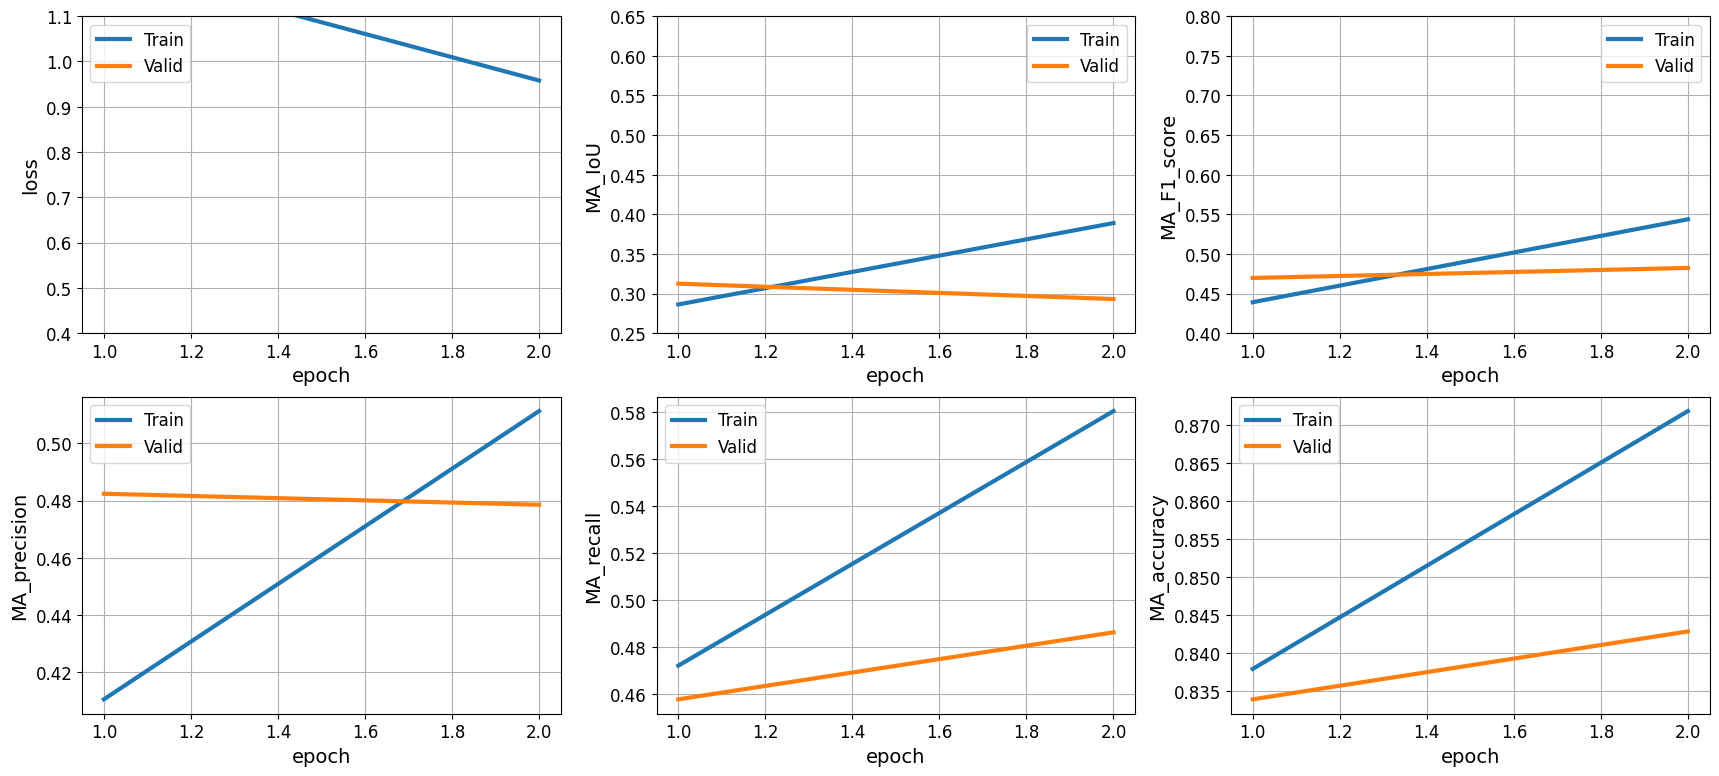

In [34]:
N_EPOCHS = 2
TRAIN = True

if TRAIN:
    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          "checkpoint_deeplab.pt",
                                                          "results_deeplab.csv")
## Plot results
plot_results("checkpoint_deeplab.pt", "results_deeplab.csv")




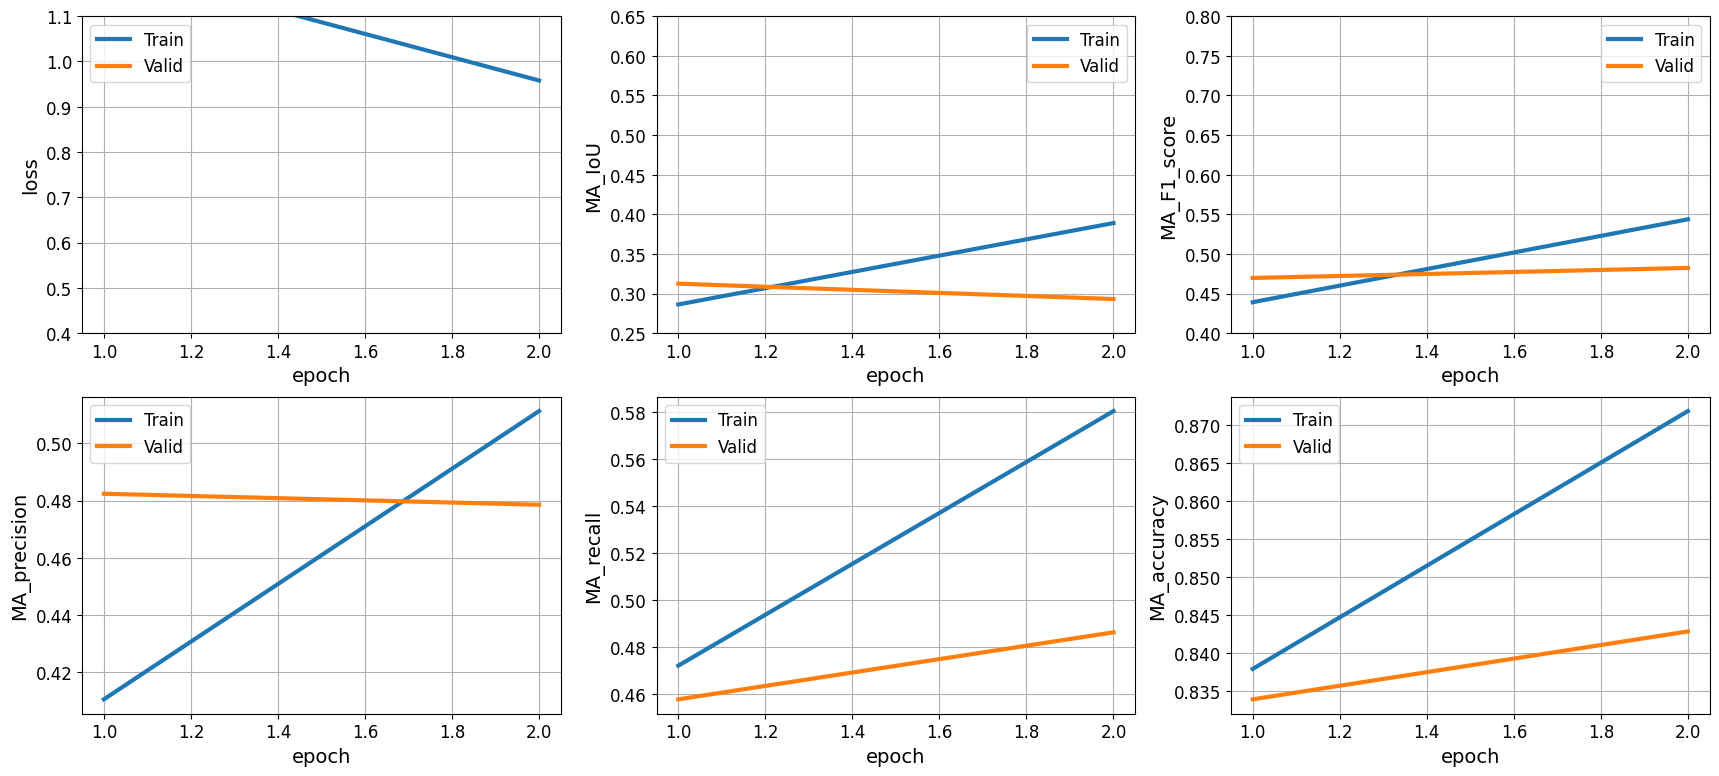

In [47]:
plot_results("checkpoint_deeplab.pt", "results_deeplab.csv")

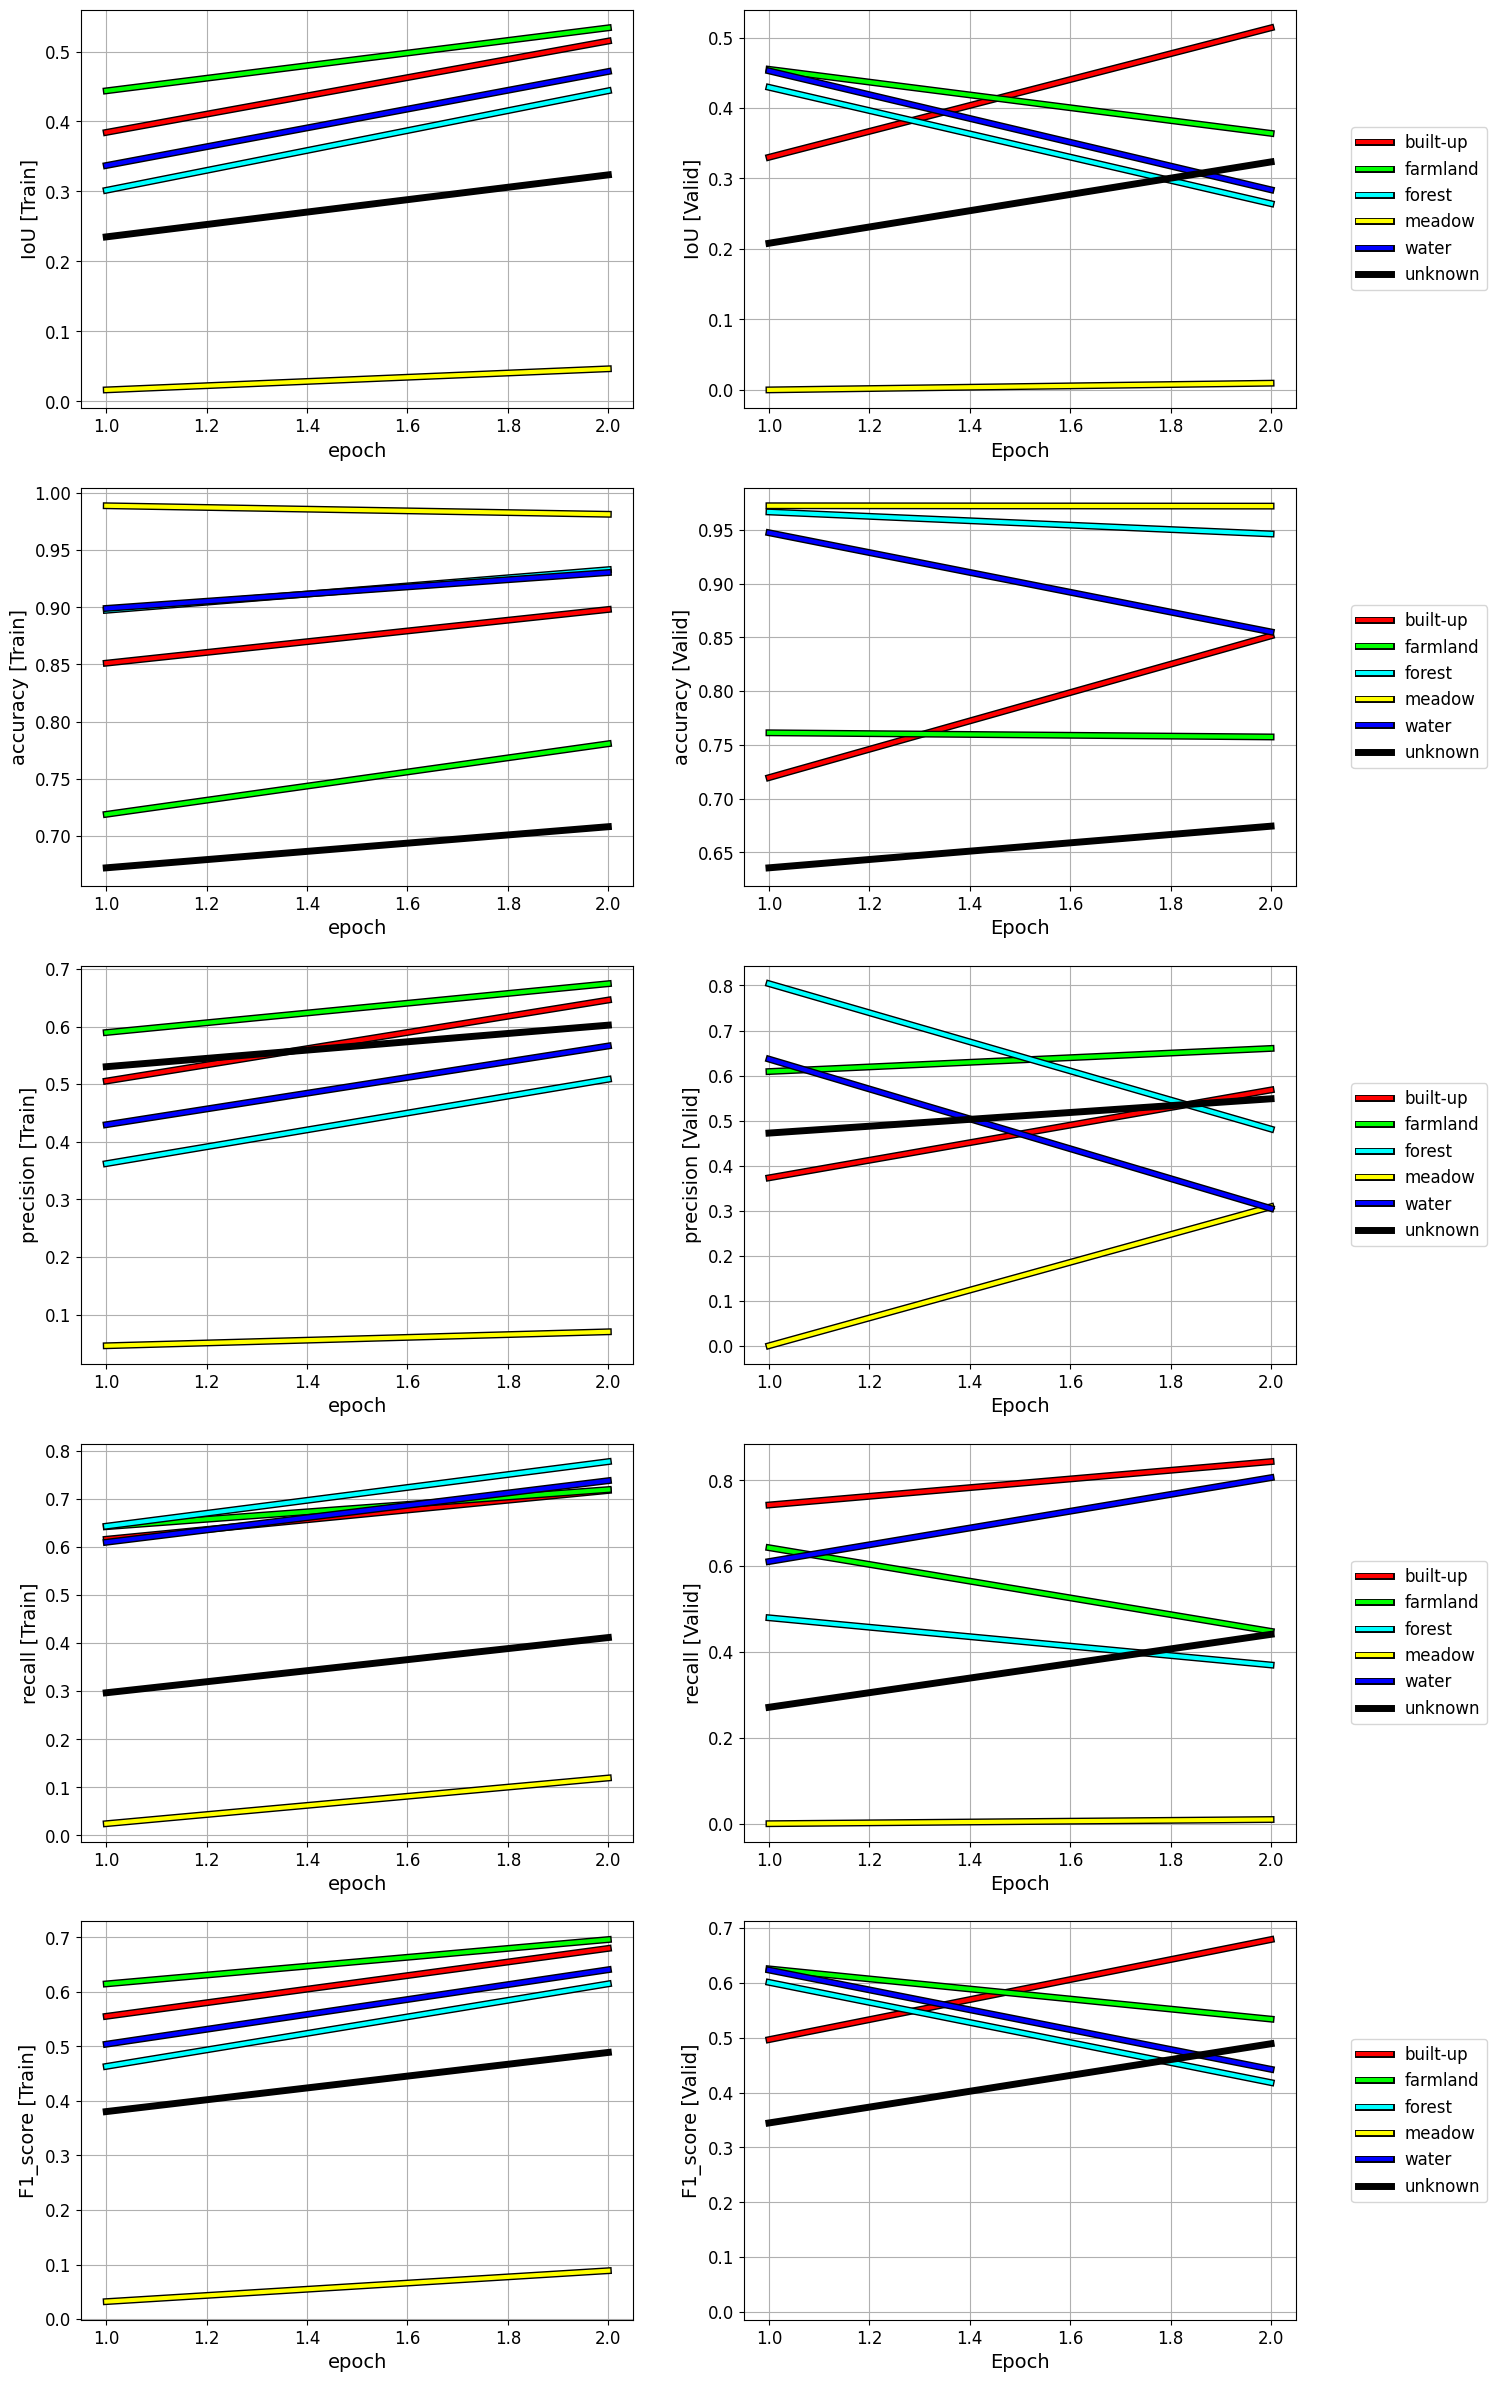

In [36]:
plot_results_per_class(class_names, class_rgb_values, "checkpoint_deeplab.pt", "results_deeplab.csv")

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    # release all unoccupied cached memory
    torch.cuda.empty_cache()
    # printo GPU info
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print("{} {} GPU available".format(str(device_count), str(device_name)))

1 NVIDIA GeForce RTX 3050 Laptop GPU GPU available


In [38]:
TEST = True

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion,
                  device,
                  "checkpoint_deeplab.pt",
                  "results_deeplab.csv",
                  "confusion_matrixdl.csv")


Test: 100%|██████████| 2744/2744 [02:54<00:00, 15.75it/s]


In [39]:
pd.read_csv("./results/test_results_deeplab.csv").iloc[:,np.arange(0, 12, 2)].style.hide()

loss,MA_IoU,MA_accuracy,MA_precision,MA_recall,MA_F1_score
2.447821,0.258283,0.818958,0.502359,0.440697,0.469512


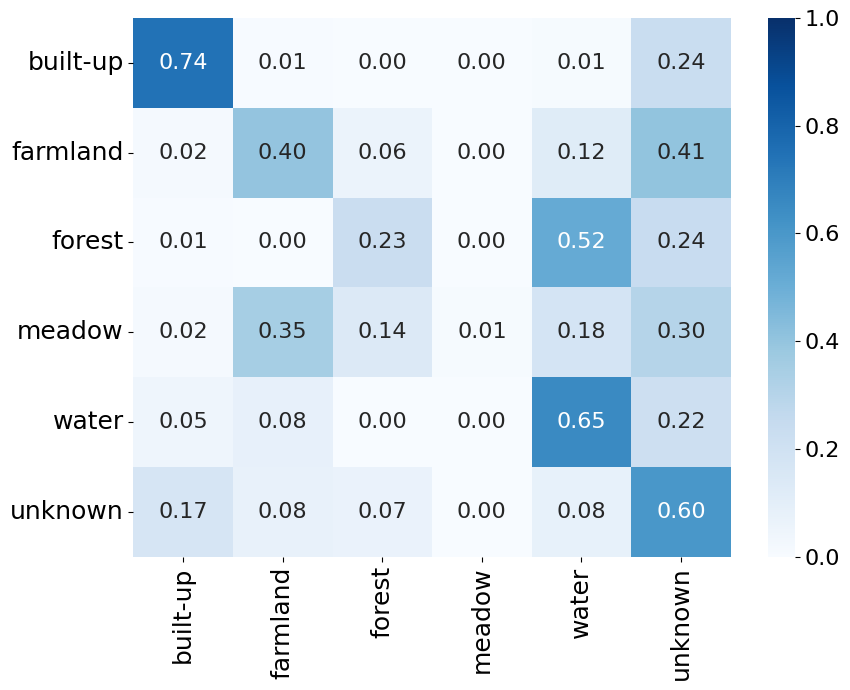

In [40]:
plot_CM(class_names, "confusion_matrixdl.csv")

In [41]:
def load_checkpoint(model, criterion, optimizer, scheduler, checkpoint_name = "checkpoint_deeplab.pt"):
    
    checkpoint = torch.load(os.path.join("./checkpoints", checkpoint_name))
    model.load_state_dict(checkpoint["model_state_dict"])
    criterion.load_state_dict(checkpoint["criterion_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if bool(checkpoint["scheduler_state_dict"]):
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        
    return model, criterion, optimizer, scheduler

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    # release all unoccupied cached memory
    torch.cuda.empty_cache()
    # printo GPU info
    device_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print("{} {} GPU available".format(str(device_count), str(device_name)))

1 NVIDIA GeForce RTX 3050 Laptop GPU GPU available


In [43]:
model = DeepLabV3(n_classes=6)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight = torch.from_numpy(class_weight).float())
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

scheduler = None

N_EPOCHS = 3

# load checkpoint
model, criterion, optimizer, scheduler = load_checkpoint(model,
                                                         criterion,
                                                         optimizer,
                                                         scheduler,
                                                         checkpoint_name = "checkpoint_deeplab.pt")

c:\Users\oswal\miniconda3\envs\cudapy\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\oswal\miniconda3\envs\cudapy\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
TRAIN = True

if TRAIN:
    train_metrics_log, valid_metrics_log = model_training(N_EPOCHS,
                                                          model,
                                                          train_iterator,
                                                          valid_iterator,
                                                          criterion,
                                                          optimizer,
                                                          scheduler,
                                                          device,
                                                          "checkpoint_1deeplab.pt",
                                                          "results_1deeplab.csv")

----------------------------------------------------------

Epoch: 1/3



Valid: 100%|██████████| 2352/2352 [01:39<00:00, 23.52it/s]



Train: Loss = 0.8973, MA_IoU = 41.42 %, MA_acc = 87.93 %, MA_prec = 53.53 %, MA_rec = 61.56 %, MA_F1_score = 57.27 %
Valid: Loss = 1.2383, MA_IoU = 37.98 %, MA_acc = 85.68 %, MA_prec = 62.09 %, MA_rec = 55.72 %, MA_F1_score = 58.73 %

Epoch Time: 4619.63 s

----------------------------------------------------------

Epoch: 2/3



Valid: 100%|██████████| 2352/2352 [01:35<00:00, 24.57it/s]



Train: Loss = 0.8242, MA_IoU = 44.50 %, MA_acc = 88.79 %, MA_prec = 56.38 %, MA_rec = 66.07 %, MA_F1_score = 60.84 %
Valid: Loss = 1.4504, MA_IoU = 34.21 %, MA_acc = 83.42 %, MA_prec = 61.15 %, MA_rec = 50.01 %, MA_F1_score = 55.02 %

Epoch Time: 4539.36 s

----------------------------------------------------------

Epoch: 3/3



Valid: 100%|██████████| 2352/2352 [01:36<00:00, 24.41it/s]



Train: Loss = 0.7637, MA_IoU = 47.05 %, MA_acc = 89.51 %, MA_prec = 58.71 %, MA_rec = 69.85 %, MA_F1_score = 63.80 %
Valid: Loss = 1.0766, MA_IoU = 39.41 %, MA_acc = 85.35 %, MA_prec = 56.02 %, MA_rec = 65.24 %, MA_F1_score = 60.28 %

Epoch Time: 4598.72 s

----------------------------------------------------------


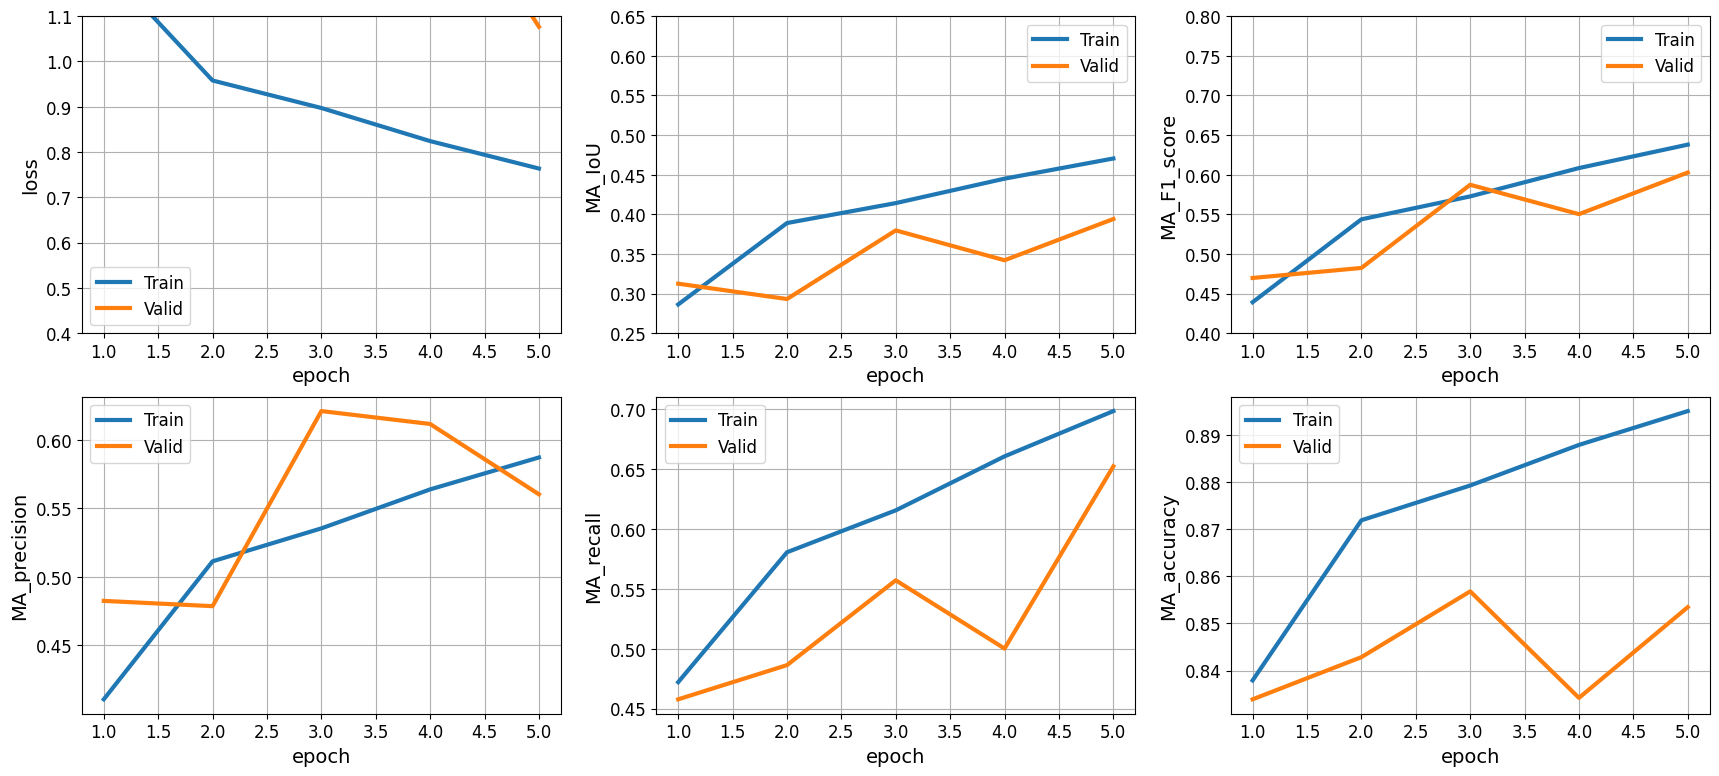

In [48]:
plot_results(["checkpoint_deeplab.pt", "checkpoint_1deeplab.pt"], ["results_deeplab.csv", "results_1deeplab.csv"])

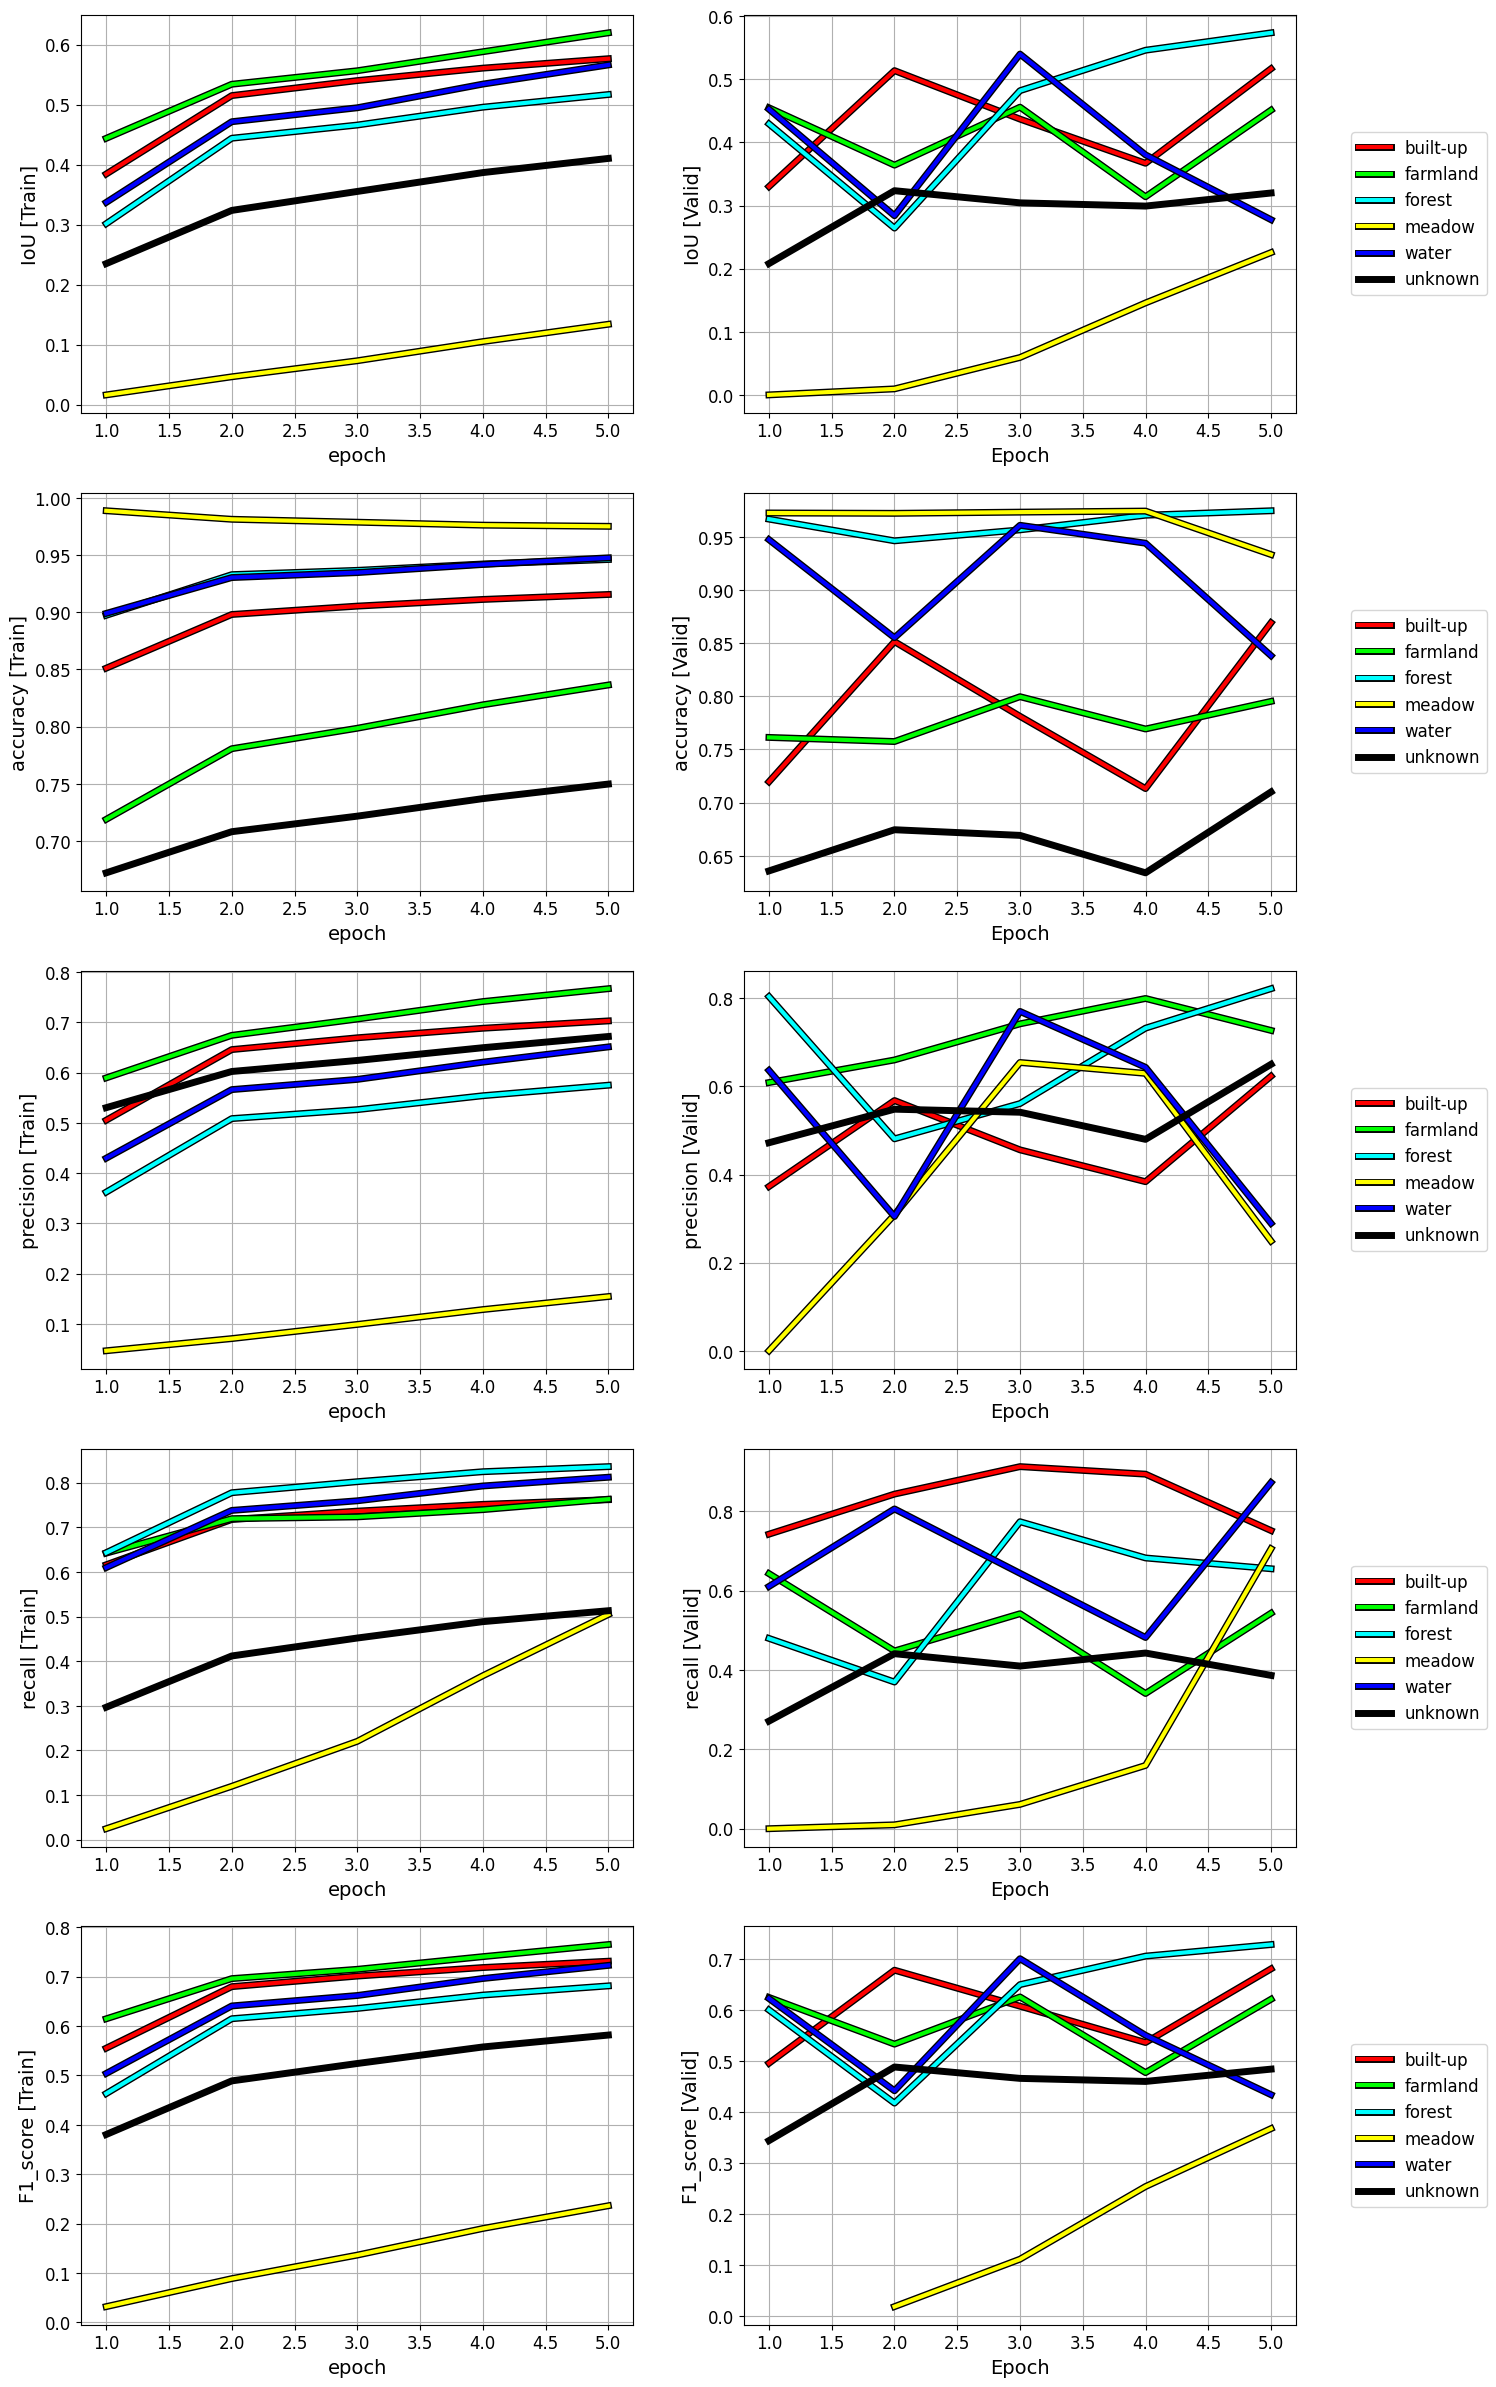

In [49]:
plot_results_per_class(class_names, class_rgb_values, ["checkpoint_deeplab.pt", "checkpoint_1deeplab.pt"], ["results_deeplab.csv", "results_1deeplab.csv"])

In [50]:
def plot_results_per_class_report(class_names, class_rgb_values, checkpoint_name = "checkpoint_deeplab.pt", results_name = "results_deeplab.csv"):
    
    # load results into dataframes constrained by checkpoint epoch
    if not isinstance(checkpoint_name, list):
        best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name))["epoch"]
        valid_results_df = pd.read_csv("./results/valid_" + results_name).iloc[:best_epoch]
    else:
        valid_frames = []
        for i in range(len(checkpoint_name)):
            best_epoch = torch.load(os.path.join("./checkpoints", checkpoint_name[i]))["epoch"]
            valid_frames.append(pd.read_csv("./results/valid_" + results_name[i]).iloc[:best_epoch]) 
        valid_results_df = pd.concat(valid_frames, ignore_index = True)
            
    n_epochs = len(valid_results_df)
    n_classes = len(class_names) 
    valid_metric = np.zeros((n_epochs, n_classes))
    for i in range(n_epochs):
        valid_metric[i] = np.array(json.loads(valid_results_df["IoU"].iloc[i].replace("nan", "NaN")))
     
    plt.figure(figsize = (10, 7))   
    plt.subplot(1,1,1)
    
    for i in range(n_classes): 
        plt.plot(np.arange(n_epochs) + 1, valid_metric[:,i],
                 linewidth = 3,
                 color = np.array(class_rgb_values[i])/255,
                 label = [s.split("_")[0] for s in class_names][i],
                 path_effects = ([pe.Stroke(linewidth = 5, foreground = "black"), pe.Normal()]))
        
    plt.plot(np.arange(n_epochs) + 1, np.mean(valid_metric[:,:-1], axis = 1),
             linewidth = 4,
             linestyle = "-",
             color = "red",
             label = "MIoU")
     
    plt.xlabel("epoch", fontsize = 18)
    plt.ylabel("IoU", fontsize = 18)
    plt.xticks(fontsize = 16)
    plt.yticks(np.arange(0, 1+0.2, 0.2), fontsize = 16)
    plt.grid(ls = "--")
    
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2),
               loc = "lower left",
               mode = "expand",
               borderaxespad = 0,
               ncol = 4,
               fontsize = 18)
    
    #plt.savefig("./images/IoU_per_class_UNet.png", dpi = 300, bbox_inches = "tight")
    plt.show()

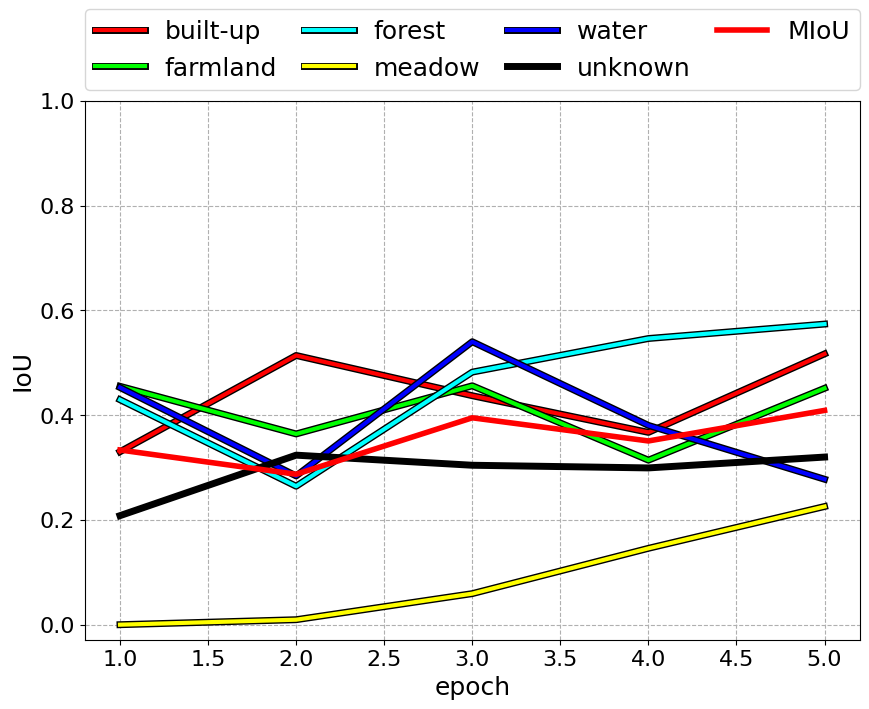

In [51]:
plot_results_per_class_report(class_names, class_rgb_values, ["checkpoint_deeplab.pt", "checkpoint_1deeplab.pt"], ["results_deeplab.csv", "results_1deeplab.csv"])

In [52]:
TEST = True

if TEST:
    model_testing(model,
                  test_iterator,
                  criterion,
                  device,
                  "checkpoint_1deeplab.pt",
                  "results_1deeplab.csv",
                  "confusion_matrix_1dl.csv")

Test: 100%|██████████| 2744/2744 [03:12<00:00, 14.28it/s]


In [53]:
pd.read_csv("./results/test_results_1deeplab.csv").iloc[:,np.arange(0, 12, 2)].style.hide()

loss,MA_IoU,MA_accuracy,MA_precision,MA_recall,MA_F1_score
1.536384,0.419081,0.870191,0.561184,0.641928,0.598846


In [54]:
for metric in ["IoU", "F1_score"]:
    arr = json.loads(pd.read_csv("./results/test_results_1deeplab.csv")[metric].iloc[-1].replace("nan", "NaN"))
    arr = np.array(arr)
    print(f"MA_{metric} (6 classes):", np.mean(arr[:-1]))

MA_IoU (6 classes): 0.444586780667305
MA_F1_score (6 classes): 0.5986411154270173


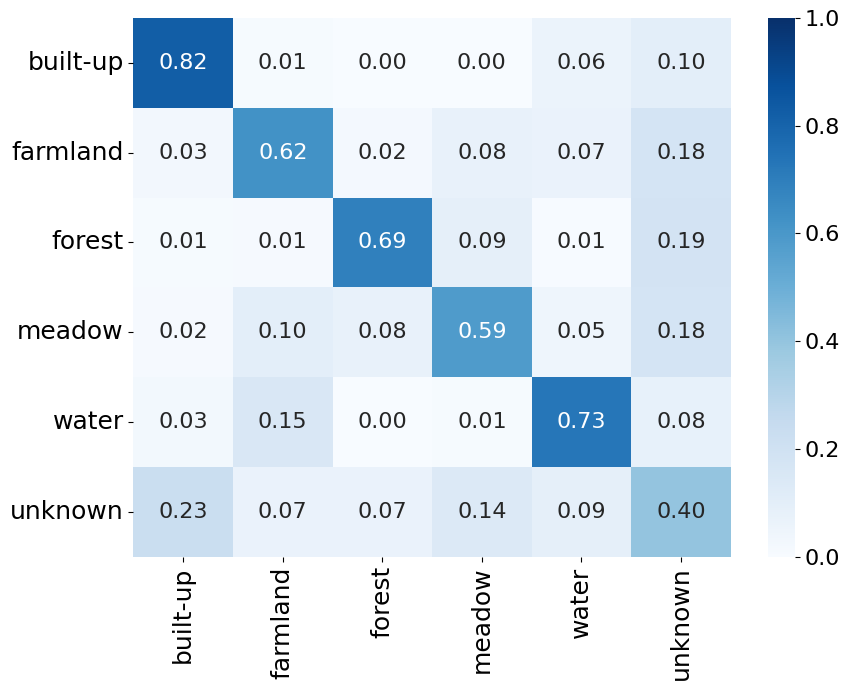

In [55]:
plot_CM(class_names, "confusion_matrix_1dl.csv")

In [56]:
metadata_df = pd.read_csv(os.path.join(DATA_PATH, "metadata.csv"))

# select only images with masks
metadata_df = metadata_df[metadata_df["split"]=="train"]

# drop "split" column
metadata_df = metadata_df[["image_id", "sat_image_path", "mask_path"]]

# modify the path of images and masks
metadata_df["sat_image_path"] = metadata_df["sat_image_path"].apply(lambda img_pth: os.path.join(DATA_PATH, img_pth))
metadata_df["mask_path"] = metadata_df["mask_path"].apply(lambda mask_pth: os.path.join(DATA_PATH, mask_pth))

metadata_df.head()

,image_id,sat_image_path,mask_path
0,GF2_PMS1__L1A0001015649-MSS1,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...
1,GF2_PMS1__L1A0001094941-MSS1,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...
2,GF2_PMS1__L1A0000575925-MSS1,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...
3,GF2_PMS1__L1A0001118839-MSS1,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...
4,GF2_PMS1__L1A0001064454-MSS1,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...,C:\Users\oswal\Documents\Kuliah\Semester 7\Pra...


In [57]:
def predict_image(model, image, mask, CUT_IMAGE=True):
    # normalize
    image = (image - train_mean) / train_std

    if CUT_IMAGE:
        patch_size = 128

        if image.shape[0] != image.shape[1]:
            raise ValueError("Image should be squared")

        crop_size = patch_size * (image.shape[0] // patch_size)

        s = image.shape[1] / 2 - crop_size / 2
        crop_image = image[int(s):int(s + crop_size), int(s):int(s + crop_size), :]
        crop_mask = mask[int(s):int(s + crop_size), int(s):int(s + crop_size), :]

        model.to(device)

        model.eval()

        torch.no_grad()

        predict_mask = np.zeros_like(crop_mask)

        for i in range(crop_image.shape[0] // patch_size):
            for j in range(crop_image.shape[0] // patch_size):

                patch = crop_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size, :]

                patch = torch.from_numpy(patch).permute(2, 0, 1).to(device)

                patch = patch[None, :]

                logits_mask = model(patch.float())['out']  # (1, C, H, W)
                prob_mask = F.softmax(logits_mask, dim=1)  # (1, C, H, W)
                pred_mask = prob_mask.argmax(dim=1)[0]  # (H, W)
                pred_mask_rgb = dense_to_rgb_encoding(pred_mask.cpu(), class_rgb_values)  # (H, W, 3)

                predict_mask[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size, :] = pred_mask_rgb

    else:
        if image.shape[0] % 16 != 0:
            raise ValueError("Image shape should be a multiple of 16")

        model.to(device)

        model.eval()

        torch.no_grad()

        sample = torch.from_numpy(image).permute(2, 0, 1)

        sample = sample[None, :]

        logits_mask = model(sample.float())['out']  # (1, C, H, W)
        prob_mask = F.softmax(logits_mask, dim=1)  # (1, C, H, W)
        pred_mask = prob_mask.argmax(dim=1)[0]  # (H, W)
        predict_mask = dense_to_rgb_encoding(pred_mask, class_rgb_values)  # (H, W, 3)

    return predict_mask


In [58]:
def plot_prediction(model, image, mask, CUT_IMAGE=True):
    pred_mask = predict_image(model, image, mask, CUT_IMAGE=CUT_IMAGE)

    if mask.shape != pred_mask.shape:
        s = image.shape[1] / 2 - pred_mask.shape[0] / 2
        image = image[int(s):int(s + pred_mask.shape[0]), int(s):int(s + pred_mask.shape[0]), :]
        mask = mask[int(s):int(s + pred_mask.shape[0]), int(s):int(s + pred_mask.shape[0]), :]

    fig = plt.figure(figsize=(15, 5))
    fig.subplots_adjust(wspace=0.02, hspace=0.02)

    idx = 1

    plt.subplot(1, 3, idx)
    idx += 1
    plt.imshow(pred_mask)
    plt.title("Prediction", fontsize=24, pad=10)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 3, idx)
    idx += 1
    plt.imshow(image)
    plt.title("Input image", fontsize=24, pad=10)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 3, idx)
    idx += 1
    plt.imshow(mask)
    plt.title("Ground truth", fontsize=24, pad=10)
    plt.xticks([])
    plt.yticks([])

    plt.savefig("./images/dl_pred_patches_2.png", dpi=300, bbox_inches="tight") if CUT_IMAGE else \
        plt.savefig("./images/dl_pred_full_2.png", dpi=300, bbox_inches="tight")

    plt.show()


selected image id: GF2_PMS1__L1A0001015649-MSS1


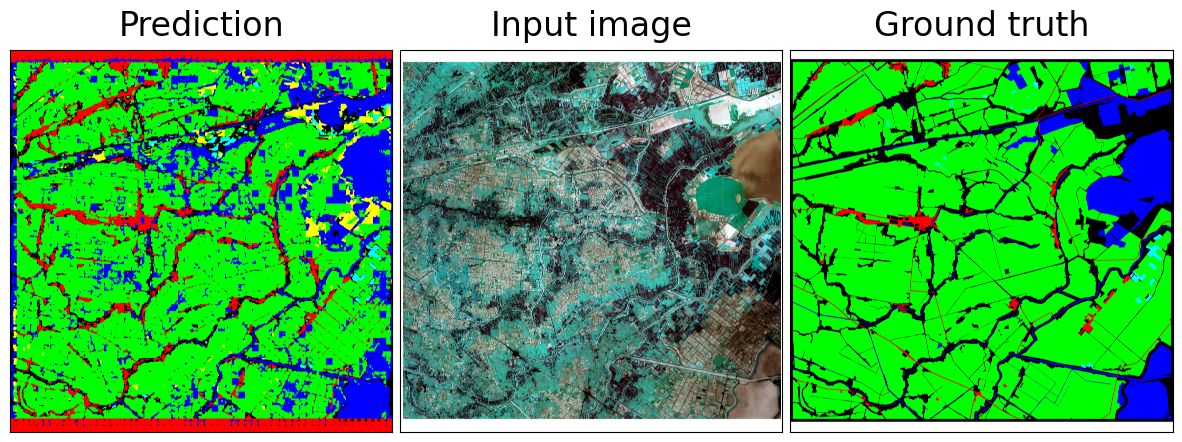

In [59]:
# [713813, 208495, 186739, 53987, 897901, 942986, 632489, 882451, 454655, 172307]
sample_image_id = 'GF2_PMS1__L1A0001015649-MSS1' #test_df["image_id"].sample(1, ignore_index = True).iloc[0]
print("selected image id:", sample_image_id)

sample_image_path = metadata_df[metadata_df["image_id"] == sample_image_id]["sat_image_path"].iloc[0]
sample_mask_path = metadata_df[metadata_df["image_id"] == sample_image_id]["mask_path"].iloc[0]

image = cv2.cvtColor(cv2.imread(sample_image_path),cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(sample_mask_path),cv2.COLOR_BGR2RGB)

plot_prediction(model, image, mask, CUT_IMAGE = True)